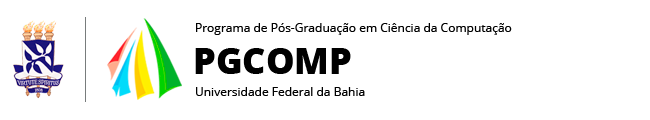

# **MATE97 - Aspectos Recente em Estatística**
## Séries temporais por Jonatas Silva do Espirito Santo

# **Série temporal**

Conjunto de observações realizadas ao longo do tempo.

Podemos classificar uma série temporal como:
- discreta ou contínua;
- univariada ou multivariada;
- unidimensional ou multidimensional.

# **Preparando o ambiente**

## **Instalando bibliotecas**

In [1]:
#Instalando biblioteca necessária
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 34.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# Instalando o NeuralProphet
!pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 2.1 MB/s 
     |████████████████████████████████| 179 kB 11.6 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


## **Carregando bibliotecas**

In [3]:
# Importando biblioteca necessária
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima


# **Air passengers**

## **Pré-Processamento**

### **Carregando o conjunto de dados**

In [4]:
# Importando o conjunto de dados de passageiros de avião d
passageiros = pd.read_csv(
    filepath_or_buffer = 'https://raw.githubusercontent.com/jonates/opendata/master/Passageiros/passageiros.csv', 
    sep=','
)

In [5]:
# Espiando a estrutura conjunto de dados
passageiros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ano_mes      144 non-null    object
 1   passageiros  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
passageiros.head()

,ano_mes,passageiros
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### **Transformando o conjunto de dados**

In [7]:
# Transferindo a coluna ano_mes para o índice
passageiros = passageiros.set_index('ano_mes')

In [8]:
# Espiando o resultado
passageiros

,passageiros
ano_mes,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


In [10]:
# Alterando o tipo do índice para DatetimeIndex com frequência mensal
passageiros.index = pd.DatetimeIndex(passageiros.index ,freq='MS')

In [11]:
# Verificando o tipo do índice do dataframe
passageiros.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='ano_mes', length=144, freq='MS')

In [12]:
# Criando a  Serie temporal
st_completa = pd.Series(
    data = passageiros['passageiros'].values, 
    index = passageiros.index
)

# Espiando o resultado
st_completa

ano_mes
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Length: 144, dtype: int64

In [13]:
# Criando a  Serie temporal de treino
st_treino = pd.Series(
    data = passageiros.query('ano_mes<"1960-01-01"')['passageiros'].values, 
    index = passageiros.query('ano_mes<"1960-01-01"').index
)

# Espiando o resultado da Serie temporal de treino
st_treino

ano_mes
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
Freq: MS, Length: 132, dtype: int64

In [14]:
# Criando a  Serie temporal de teste
st_teste = pd.Series(
    data = passageiros.query('ano_mes>="1960-01-01"')['passageiros'].values, 
    index = passageiros.query('ano_mes>="1960-01-01"').index
)

# Espiando o resultado da Serie temporal de teste
st_teste

ano_mes
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, dtype: int64

## **Análise Exploratória**

### **Visualização da Série**

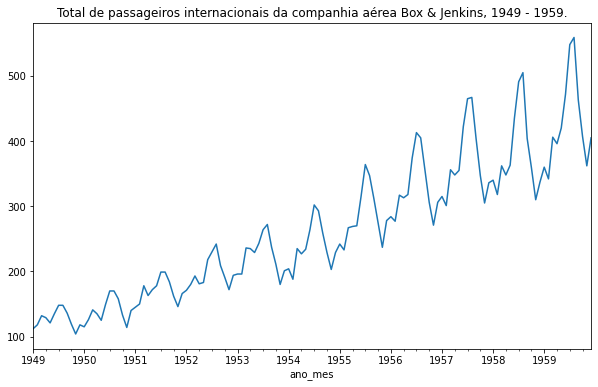

In [15]:
# Gerando o gráfico da Serie
st_treino.plot(
    title = 'Total de passageiros internacionais da companhia aérea Box & Jenkins, 1949 - 1959.',
    figsize =(10, 6)
);

### **Decomposição da série**

**Componentes de uma série temporal**
- **Tendência**
- **Ciclo**
- **Sazonalidade**
- **Resíduo**

- **Modelo aditivo:** Serie = Tendência **+** Sazonalidade **+** Ruído
- **Modelo Multiplicativo:** Serie = Tendência **x** Sazonalidade **x** Ruído

In [25]:
# Decompondo a série
decomposicao = seasonal_decompose(st_treino,model='multiplicative')

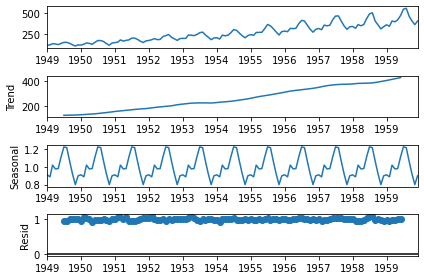

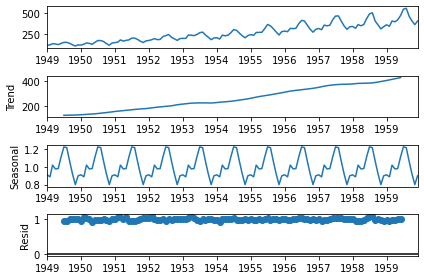

In [27]:
# Fazendo gráficos da decomposição
decomposicao.plot()

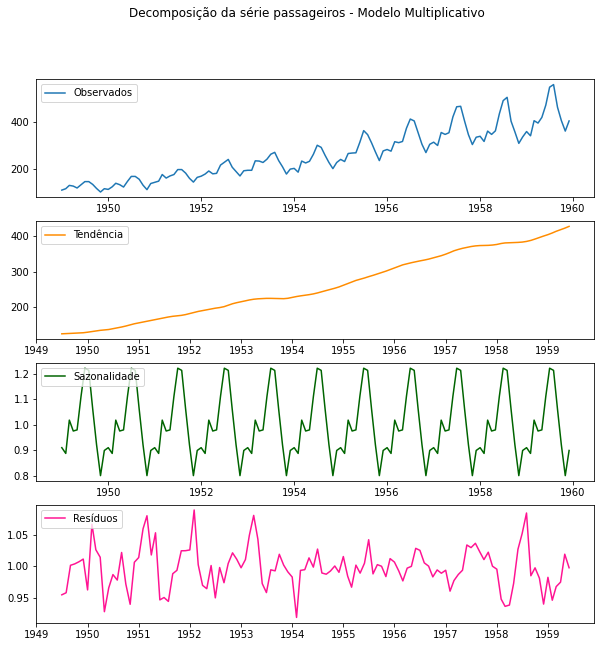

In [26]:
# Fazendo os gráficos de decomposição de forma elegante

# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (10,10), ncols = 1, nrows = 4)

# Gráfico com valores observados
ax[0].plot(decomposicao.observed, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com a tendência
ax[1].plot(decomposicao.trend, color = 'darkorange', label='Tendência')
ax[1].legend(loc='upper left')

# Gráfico com a Sazonalidade
ax[2].plot(decomposicao.seasonal, color = 'darkgreen', label='Sazonalidade')
ax[2].legend(loc='upper left')

# Gráfico com os resíduos
ax[3].plot(decomposicao.resid, color = 'deeppink', label='Resíduos')
ax[3].legend(loc='upper left')

# Alterando o título
fig.suptitle('Decomposição da série passageiros - Modelo Multiplicativo');

# Exibindo o gráfico
plt.show()

### **Teste de estacionaridade - (Dickey Fuller)**

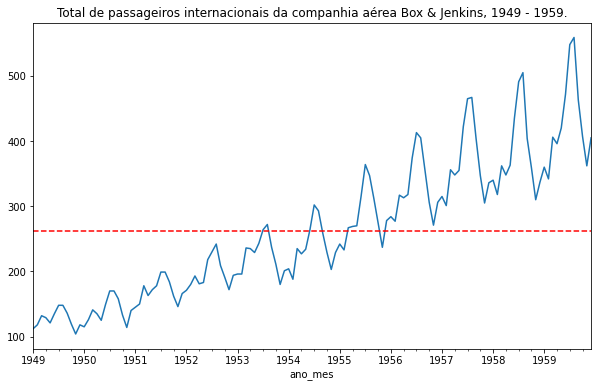

In [28]:
# Gerando o gráfico
st_treino.plot(
    title = 'Total de passageiros internacionais da companhia aérea Box & Jenkins, 1949 - 1959.',
    figsize =(10, 6)
)

# Inserindo uma linha horizontal com a média dos dados
plt.axhline (y=st_treino.mean(), color = 'red', linestyle = '--')

# Exibindo o gráfico
plt.show()

- **Hipótese nula (Ho):** a série *não é estacionária*
- **Hipótese Alternativa (Ha):** a série *é estacionária*

In [30]:
# Calculando as medidas do teste Dickey Fuller
df = statsmodels.tsa.stattools.adfuller(st_treino)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: 0.8880
p-valor do teste: 0.99293206
Valores Críticos:
1%: -3.4870
5%: -2.8864
10%: -2.5800


Como a estatística do teste é maior que o valor crítico podemos considerar que NÃO existem evidências suficientes para rejeitar a hipótese nula, ou seja, a nível de 1% de significância NÃO existem evidências de que a série é estacionária.

### **Diferenciação**

Uma estratégia para tornar uma série estacionária é fazer a diferenciação $y^{'}_t=y_t - y_{t-1}$, também chamada de série diferenciada de primeira ordem. Caso a série não se torne estacionária, pode diferenciar novamente até encontrar o **d** (grau de diferenciação) ótimo.

In [29]:
# Encontrando a diferença de primeira ordem
st_treino_1_dif = st_treino.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
st_treino_1_dif.dropna(inplace = True)

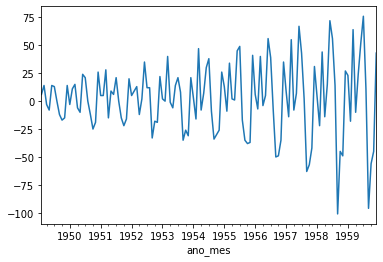

In [30]:
# Gerando o gráfico
st_treino_1_dif.plot()
plt.show()

In [31]:
# Calculando as medidas do teste Dickey Fuller
# **Hipótese nula (Ho):** a série *não é estacionária*
# **Hipótese Alternativa (Ha):** a série *é estacionária*
df = statsmodels.tsa.stattools.adfuller(st_treino_1_dif)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -2.4029
p-valor do teste: 0.14091389
Valores Críticos:
1%: -3.4875
5%: -2.8866
10%: -2.5801


### **Transformações**

#### **Transformação log**

In [32]:
# Aplicando log tornar tornar a série homocedástica
st_treino_log = np.log(st_treino)

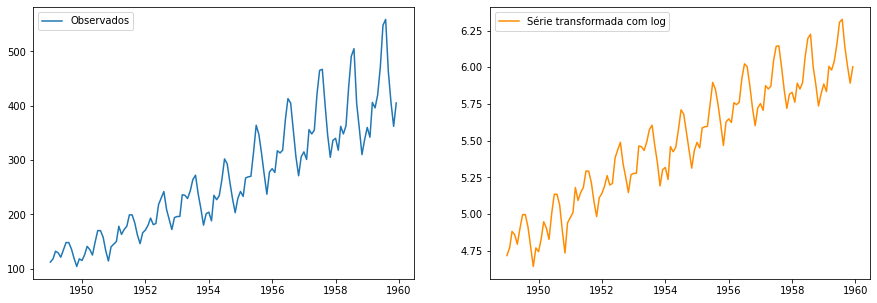

In [33]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com valores observados
ax[0].plot(st_treino, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com transformação log
ax[1].plot(st_treino_log, color = 'darkorange', label='Série transformada com log')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

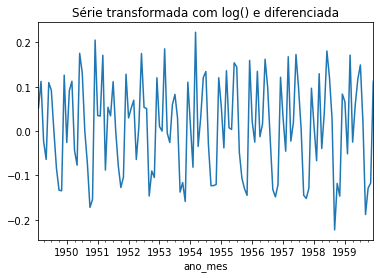

In [34]:
# Encontrando a diferença de primeira ordem da série transformada pelo log
st_treino_log_1_dif = st_treino_log.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
st_treino_log_1_dif.dropna(inplace = True)

# Gerando o gráfico da série transformada e diferenciada
st_treino_log_1_dif.plot()
plt.title('Série transformada com log() e diferenciada')
plt.show()

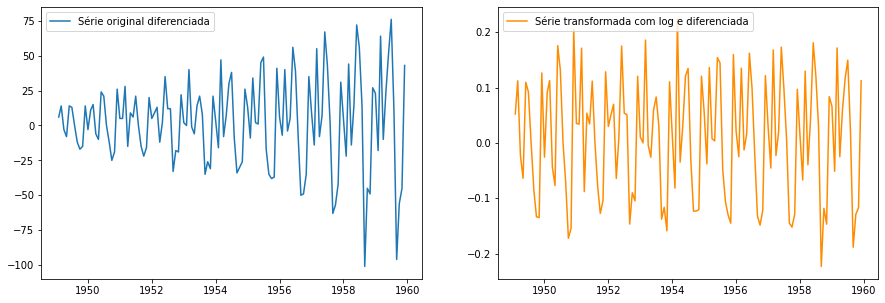

In [35]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com primeira diferença da série original
ax[0].plot(st_treino_1_dif, label='Série original diferenciada')
ax[0].legend(loc='upper left')

# Gráfico com primeira diferença da série transformada
ax[1].plot(st_treino_log_1_dif, color = 'darkorange', label='Série transformada com log e diferenciada')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

In [36]:
# Calculando as medidas do teste Dickey Fuller
# **Hipótese nula (Ho):** a série *não é estacionária*
# **Hipótese Alternativa (Ha):** a série *é estacionária*
df = statsmodels.tsa.stattools.adfuller(st_treino_log_1_dif)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -3.0647
p-valor do teste: 0.02927720
Valores Críticos:
1%: -3.4875
5%: -2.8866
10%: -2.5801


#### **Transformação Box-Cox**

- $f_\lambda(x)=\frac{x^\lambda - 1}{\lambda}$ se $\lambda \neq 0$
- $f_\lambda(x)=log(x)$ se $\lambda=0$

In [37]:
# Importando biblioteca necessária
from scipy import stats

# Aplicando log tornar tornar a série homocedástica
passageiros_boxcox, lambda_boxcox_ajustado = stats.boxcox(st_treino)

# Valor do lambda ajustado
print('Valor do lambda da transformação Box-Cox: {:.4f}'.format(lambda_boxcox_ajustado))

Valor do lambda da transformação Box-Cox: 0.1289


In [38]:
# Espiando o resultado da transformação Box-Cox
passageiros_boxcox

array([6.49406644, 6.59024935, 6.79909207, 6.75602284, 6.63675271,
       6.84131689, 7.0153397 , 7.0153397 , 6.85521025, 6.60586377,
       6.35858573, 6.59024935, 6.5427044 , 6.71207206, 6.92337022,
       6.84131689, 6.69721912, 7.02816736, 7.28158846, 7.28158846,
       7.14035926, 6.81325907, 6.52661585, 6.90990857, 6.97639848,
       7.04092024, 7.37098998, 7.2003032 , 7.30427699, 7.37098998,
       7.5900162 , 7.5900162 , 7.43577198, 7.18844381, 6.98945624,
       7.23550499, 7.29296162, 7.39279256, 7.52957569, 7.40361483,
       7.42510401, 7.77146669, 7.87908761, 7.98192357, 7.68730997,
       7.50906486, 7.30427699, 7.53976176, 7.55999742, 7.55999742,
       7.93107504, 7.92249103, 7.87030842, 7.99029132, 8.15943155,
       8.22079327, 7.93962743, 7.70628052, 7.39279256, 7.60981044,
       7.63918247, 7.47794503, 7.92249103, 7.85264939, 7.91387513,
       8.15943155, 8.4377193 , 8.37468989, 8.12025275, 7.87030842,
       7.62943385, 7.87030842, 7.98192357, 7.9052271 , 8.18262

In [39]:
# Criando a  Serie temporal
st_treino_boxcox = pd.Series(
    data = passageiros_boxcox, 
    index = st_treino.index
)

# Espiando o resultado
st_treino_boxcox

ano_mes
1949-01-01    6.494066
1949-02-01    6.590249
1949-03-01    6.799092
1949-04-01    6.756023
1949-05-01    6.636753
                ...   
1959-08-01    9.775331
1959-09-01    9.354671
1959-10-01    9.072694
1959-11-01    8.820439
1959-12-01    9.062012
Freq: MS, Length: 132, dtype: float64

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

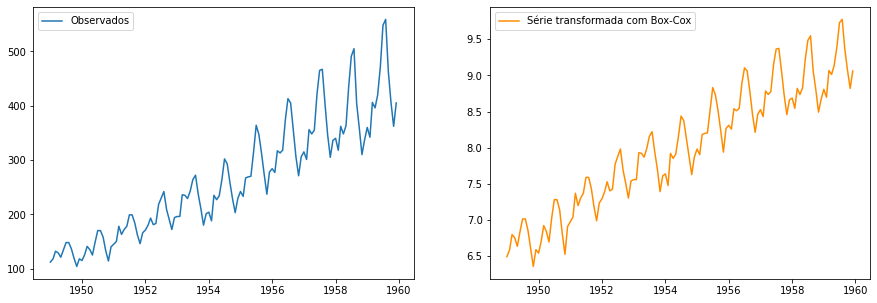

In [40]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com primeira diferença da série original
ax[0].plot(st_treino, label='Observados')
ax[0].legend(loc='upper left')

# Gráfico com primeira diferença da série transformada
ax[1].plot(st_treino_boxcox, color = 'darkorange', label='Série transformada com Box-Cox')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

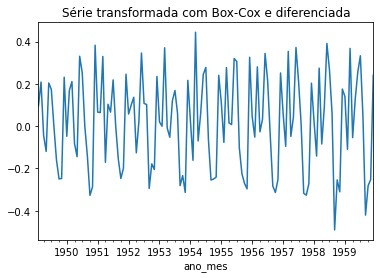

In [41]:
# Encontrando a diferença de primeira ordem da série transformada pela Box-Cox
st_treino_boxcox_1_dif = st_treino_boxcox.diff()

# Retirando o NA gerado pela falta de valores antes da primeira observação
st_treino_boxcox_1_dif.dropna(inplace = True)

# Gerando o gráfico da série transformada e diferenciada
st_treino_boxcox_1_dif.plot()
plt.title('Série transformada com Box-Cox e diferenciada')
plt.show()

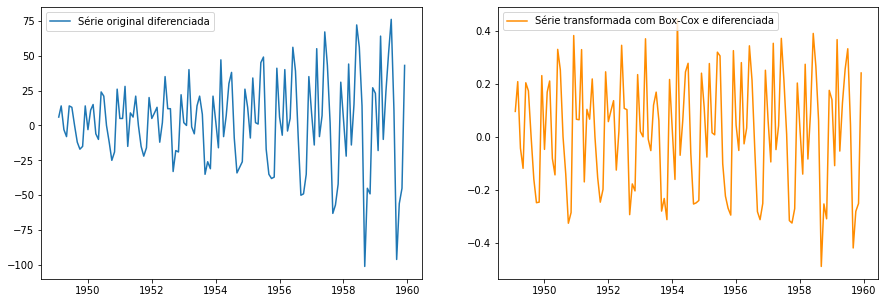

In [42]:
# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

# Gráfico com primeira diferença da série original
ax[0].plot(st_treino_1_dif, label='Série original diferenciada')
ax[0].legend(loc='upper left')

# Gráfico com primeira diferença da série transformada
ax[1].plot(st_treino_boxcox_1_dif, color = 'darkorange', label='Série transformada com Box-Cox e diferenciada')
ax[1].legend(loc='upper left')

# Exibindo o gráfico
plt.show()

In [43]:
# Calculando as medidas do teste Dickey Fuller
# **Hipótese nula (Ho):** a série *não é estacionária*
# **Hipótese Alternativa (Ha):** a série *é estacionária*
df = statsmodels.tsa.stattools.adfuller(st_treino_boxcox_1_dif)

print('Estatítica do teste: {:.4f}'.format(df[0]))
print('p-valor do teste: {:.8f}'.format(df[1]))
print('Valores Críticos:')
for chave, valor in df[4].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: -3.1139
p-valor do teste: 0.02554359
Valores Críticos:
1%: -3.4875
5%: -2.8866
10%: -2.5801


### **Auto Correlação da série transformada**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


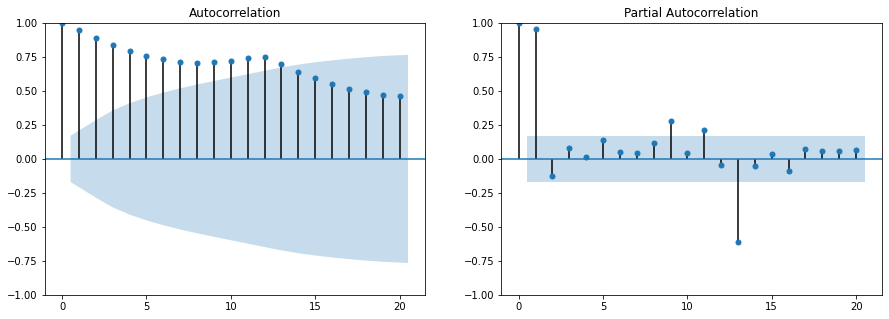

In [44]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(st_treino_log, lags=20, ax=ax[0])
plot_pacf(st_treino_log, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

### **Auto Correlação da série transformada e diferenciada**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


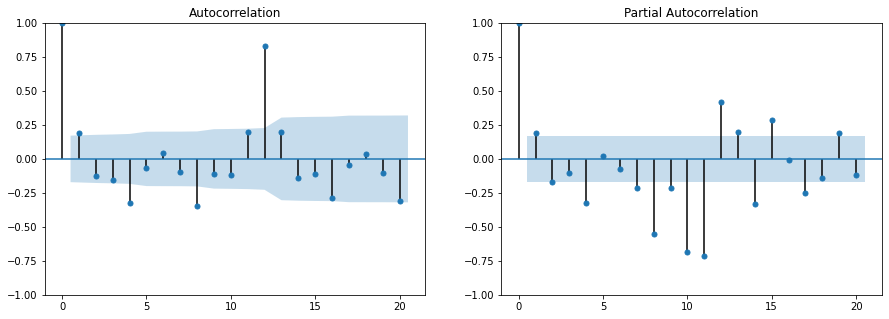

In [45]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(st_treino_log_1_dif, lags=20, ax=ax[0])
plot_pacf(st_treino_log_1_dif, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

## **Modelos Box-Jenkins das série transformada**

**Modelos ARIMA**
- **AR (p) - Auto Regressivo:** $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ...+ \phi_p y_{t-p} + e_t$
- **MA (q) - Média Móvel:** $y_t = c  + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q y_{t-q}$
- **ARIMA (p,d,q):** $y^{'}_t = c + \phi_1 y^{'}_{t-1} + \phi_2 y^{'}_{t-2} + ... \phi_p y^{'}_{t-p} + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ...+ \theta_q y_{t-q} + e_t$

sendo que $p$ é a ordem do modelos **AR**, $q$ é a ordem do modelo **MA**, e $d$ é o grau de diferenciação.

### **Modelo ARIMA(1,0,1)(1,0,1)**

Um modelo ARIMA (p,d,q) com o grau de diferenciação igual a zero temos ARIMA(p,0,q) resulta em um modelo Auto regressivo e de média móvel de ordem p,q: ARMA(p,q). Para modelar também a sazonalidade insere os parâmetros (P,D,Q).

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


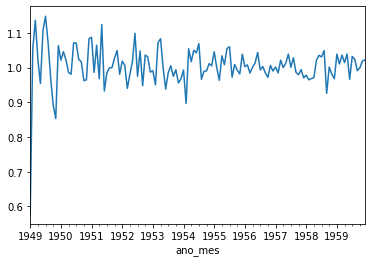

In [46]:
# Definindo Ajustando um modelo ARIMA(1,0,1)(1,0,1) com ajuste sazonal
modelo_arima_1_0_1_1_0_1 = statsmodels.tsa.arima.model.ARIMA(
    st_treino_log, 
    order = (1,0,1), 
    seasonal_order = (1, 0, 1, 12)
)

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_0_1_1_0_1 = modelo_arima_1_0_1_1_0_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_0_1_1_0_1 = np.exp(resultado_arima_1_0_1_1_0_1.resid)

# Visualizando os resíduos
residuos_arima_1_0_1_1_0_1.plot()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


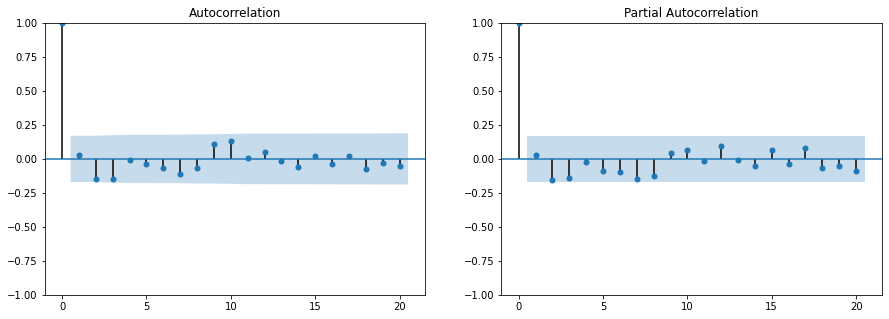

In [47]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_0_1_1_0_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_0_1_1_0_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


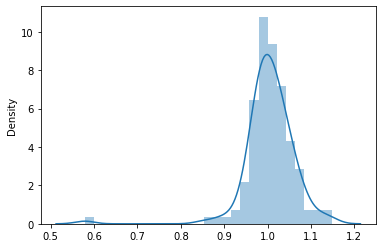

In [52]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_0_1_1_0_1);

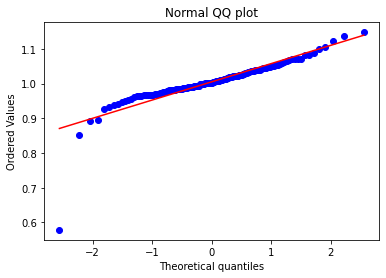

In [53]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_0_1_1_0_1, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

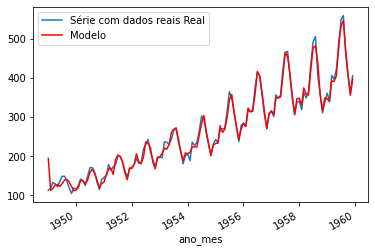

In [48]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_treino, label='Série com dados reais Real')
np.exp(resultado_arima_1_0_1_1_0_1.predict()).plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Modelo ARIMA(1,1,1)(1,1,1)**

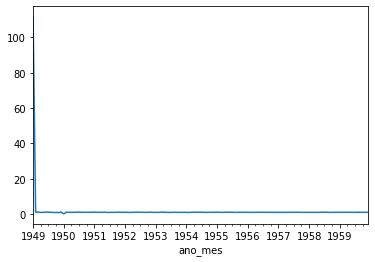

In [59]:
# Definindo Ajustando um modelo ARIMA(1,1,1)(1,1,1) com ajuste sazonal
modelo_arima_1_1_1_1_1_1 = statsmodels.tsa.arima.model.ARIMA(
    st_treino_log, 
    order = (1,1,1), 
    seasonal_order = (1, 1, 1, 12)
)

# Ajustando o modelo e guardando os resultado em um objeto
resultado_arima_1_1_1_1_1_1 = modelo_arima_1_1_1_1_1_1.fit()

# Pegando os resíduos do modelo
residuos_arima_1_1_1_1_1_1 = np.exp(resultado_arima_1_1_1_1_1_1.resid)

# Visualizando os resíduos
residuos_arima_1_1_1_1_1_1.plot()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


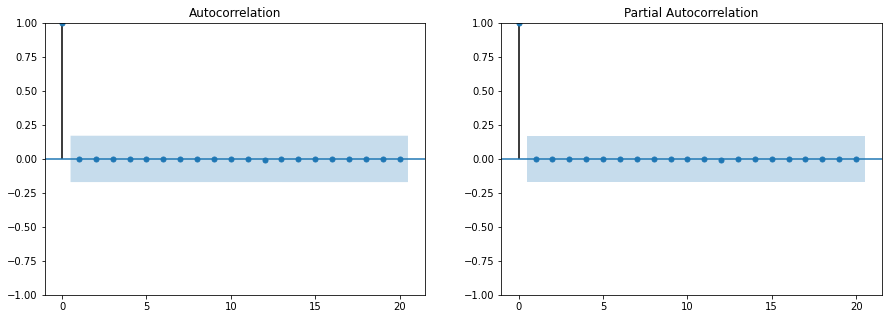

In [60]:
# Definindo o tamanho da figura e disposições dos subplots
fig, ax = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1)

 # Fazendo o gráfico de autocorrelação e autocorrelação  parcial
plot_acf(residuos_arima_1_1_1_1_1_1, lags=20, ax=ax[0])
plot_pacf(residuos_arima_1_1_1_1_1_1, lags=20, ax=ax[1])

# Exibindo o gráfico
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


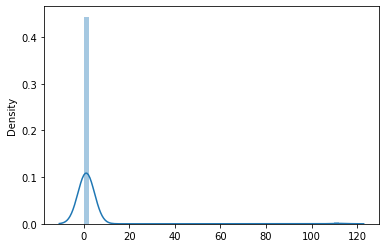

In [61]:
# Visualizando a distribuição dos resíduos
sns.distplot(residuos_arima_1_1_1_1_1_1);

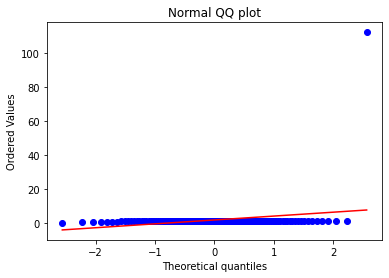

In [62]:
# Verificando a normalidade dos resíduos através do QQ plot
stats.probplot(residuos_arima_1_1_1_1_1_1, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

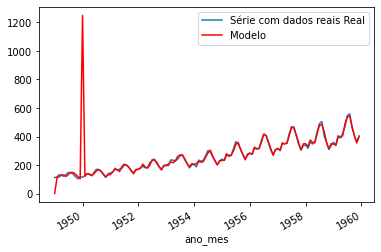

In [63]:
# Plotando a série com dados reais e ajustados pelo modelo
plt.plot(st_treino, label='Série com dados reais Real')
np.exp(resultado_arima_1_1_1_1_1_1.predict()).plot(color='red', label='Modelo')
plt.legend(loc='best')
plt.show()

### **Analisando o Critério de Informação de Akaike - AIC**

In [64]:
# Verificando o valor do Critério de Informação de Akaike - AIC
print('ARIMA(1,0,1)(1,0,1): AIC = {}'.format(resultado_arima_1_0_1_1_0_1.aic))
print('ARIMA(1,1,1)(1,1,1): AIC = {}'.format(resultado_arima_1_1_1_1_1_1.aic))

ARIMA(1,0,1)(1,0,1): AIC = -450.30608805487145
ARIMA(1,1,1)(1,1,1): AIC = -437.018110006572


### **Previsão**

In [65]:
# Predizendo com o modelo ARIMA(1,0,1)(1,0,1)
previsao_arima_1_0_1_1_0_1_log = resultado_arima_1_0_1_1_0_1.forecast(12)
previsao_arima_1_0_1_1_0_1 = np.exp(previsao_arima_1_0_1_1_0_1_log)
previsao_arima_1_0_1_1_0_1

1960-01-01    418.113853
1960-02-01    396.947788
1960-03-01    461.542637
1960-04-01    448.629157
1960-05-01    466.239921
1960-06-01    535.597034
1960-07-01    606.371369
1960-08-01    612.955864
1960-09-01    512.500721
1960-10-01    450.229268
1960-11-01    396.438541
1960-12-01    438.655334
Freq: MS, Name: predicted_mean, dtype: float64

In [66]:
# Predizendo com o modelo ARIMA(1,1,1)(1,1,1)
previsao_arima_1_1_1_1_1_1_log = resultado_arima_1_1_1_1_1_1.forecast(12)
previsao_arima_1_1_1_1_1_1 = np.exp(previsao_arima_1_1_1_1_1_1_log)
previsao_arima_1_1_1_1_1_1

1960-01-01    419.338824
1960-02-01    398.542176
1960-03-01    465.275861
1960-04-01    452.813739
1960-05-01    471.964246
1960-06-01    547.467120
1960-07-01    622.274572
1960-08-01    631.087147
1960-09-01    525.446736
1960-10-01    461.295612
1960-11-01    405.302325
1960-12-01    449.760717
Freq: MS, Name: predicted_mean, dtype: float64

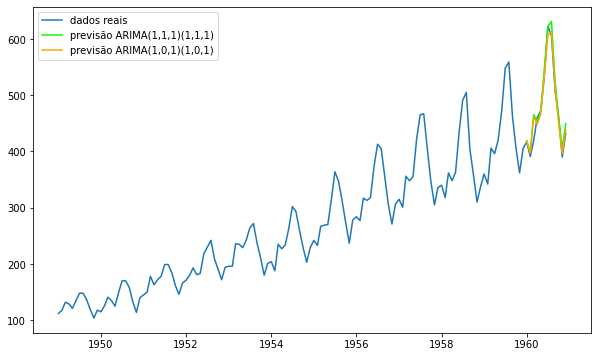

In [67]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_completa, label='dados reais')
plt.plot(previsao_arima_1_1_1_1_1_1,color='lime', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.plot(previsao_arima_1_0_1_1_0_1,color='orange', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.legend(loc='best')
plt.show()

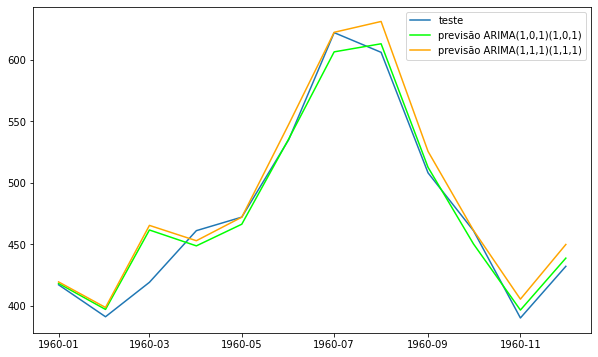

In [68]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_teste, label='teste')
plt.plot(previsao_arima_1_0_1_1_0_1,color='lime', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.plot(previsao_arima_1_1_1_1_1_1,color='orange', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.legend(loc='best')
plt.show()

In [70]:
## Calculando métrica de avaliação do modelo de previsão
## erro médio absoluto (MAE) - meanabs
## raiz do erro quadrático médio (RMSE) - rmse

# Carregando bibliotecas necessárias
from statsmodels.tools.eval_measures import meanabs, rmse

# Calculando as métricas para previsão com ARIMA(1,0,1)(1,0,1)
mae_arima_1_0_1_1_0_1 = meanabs(st_teste,previsao_arima_1_0_1_1_0_1)
rmse_arima_1_0_1_1_0_1 = rmse(st_teste,previsao_arima_1_0_1_1_0_1)

# Calculando as métricas para previsão com ARIMA(1,1,1)(1,1,1)
mae_arima_1_1_1_1_1_1 = meanabs(st_teste,previsao_arima_1_1_1_1_1_1)
rmse_arima_1_1_1_1_1_1 = rmse(st_teste,previsao_arima_1_1_1_1_1_1)

In [71]:
# Comparando as métricas de avaliação das performances dos modelos de predição
print('Comparando os Erros Médios Absolutos')
print('ARIMA(1,0,1)(1,0,1): MAE = {}'.format(mae_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): MAE = {}'.format(mae_arima_1_1_1_1_1_1))

print('\n Comparando as Raízes dos Erros Quadráticos Médios')
print('ARIMA(1,0,1)(1,0,1): RMSE = {}'.format(rmse_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): RMSE = {}'.format(rmse_arima_1_1_1_1_1_1))



Comparando os Erros Médios Absolutos
ARIMA(1,0,1)(1,0,1): MAE = 9.940171443338633
ARIMA(1,1,1)(1,1,1): MAE = 12.751092120208568

 Comparando as Raízes dos Erros Quadráticos Médios
ARIMA(1,0,1)(1,0,1): RMSE = 14.570853109952024
ARIMA(1,1,1)(1,1,1): RMSE = 18.05033608482443



## **Auto ARIMA**

### **Ajustando Auto ARIMA**

In [72]:
### AUTOARIMA
modelo_autoarima = auto_arima(
    y = st_treino_log, 
    trace = True, 
    stepwise = False, 
    seasonal=True, 
    with_intercept = False,
    start_p=0, 
    start_d=0, 
    start_q=0, 
    max_p=2,
    max_d=1, 
    max_q=2,
    start_P=0, 
    start_D=0, 
    start_Q=0, 
    max_P=2,
    max_D=1, 
    max_Q=2,
    m=12)

 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-134.983, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12]             : AIC=-171.855, Time=0.18 sec
 ARIMA(0,0,0)(0,1,2)[12]             : AIC=-203.600, Time=0.70 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=-214.100, Time=0.12 sec
 ARIMA(0,0,0)(1,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(1,1,2)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(2,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(2,1,2)[12]             : AIC=inf, Time=3.39 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=-233.024, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=-248.188, Time=0.42 sec
 ARIMA(0,0,1)(0,1,2)[12]             : AIC=-262.689, Time=1.90 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=-267.075, Time=0.24 sec
 ARIMA(0,0,1)(1,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,0,1)(1,1,2)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(0,0,1)(2,1,0)[12]      

### **Realizando Previsões com o autoARIMA**

In [73]:
# # Ajustando o modelo selecionado aos dados e Predizendo 3 períodos
previsao_autoarima_log = modelo_autoarima.fit(st_treino_log).predict(n_periods=12)
previsao_autoarima = np.exp(previsao_autoarima_log)
previsao_autoarima

array([418.64750175, 397.79506101, 464.76139259, 452.1289382 ,
       470.43645019, 543.22991633, 617.182414  , 624.42515187,
       521.2933732 , 457.01740924, 401.56937054, 446.16910208])

### **Avaliando a qualidade da previsão do AutoARIMA**

In [74]:
## Calculando métrica de avaliação do modelo de previsão
## erro médio absoluto (MAE) - meanabs
## raiz do erro quadrático médio (RMSE) - rmse

# Carregando bibliotecas necessárias
from statsmodels.tools.eval_measures import meanabs, rmse

# Calculando as métricas para previsão com ARIMA(1,0,1)(1,0,1)
mae_autoarima = meanabs(st_teste,previsao_autoarima)
rmse_autoarima = rmse(st_teste,previsao_autoarima)

# Verificando as métricas
print('AUTOARIMA: MAE = {}'.format(mae_autoarima))
print('AUTOARIMA: RMSE = {}'.format(rmse_autoarima))

AUTOARIMA: MAE = 11.593804811222512
AUTOARIMA: RMSE = 16.28329425441231


### **Comparando performance do AutoARIMA com os outros 2 modelos ajustados**

In [75]:
# Comparando as métricas de avaliação das performances dos modelos de predição
print('Comparando os Erros Médios Absolutos')
print('ARIMA(1,0,1)(1,0,1): MAE = {}'.format(mae_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): MAE = {}'.format(mae_arima_1_1_1_1_1_1))
print('AUTOARIMA          : MAE = {}'.format(mae_autoarima))


print('\n Comparando as Raízes dos Erros Quadráticos Médios')
print('ARIMA(1,0,1)(1,0,1): RMSE = {}'.format(rmse_arima_1_0_1_1_0_1))
print('ARIMA(1,1,1)(1,1,1): RMSE = {}'.format(rmse_arima_1_1_1_1_1_1))
print('AUTOARIMA          : RMSE = {}'.format(rmse_autoarima))

Comparando os Erros Médios Absolutos
ARIMA(1,0,1)(1,0,1): MAE = 9.940171443338633
ARIMA(1,1,1)(1,1,1): MAE = 12.751092120208568
AUTOARIMA          : MAE = 11.593804811222512

 Comparando as Raízes dos Erros Quadráticos Médios
ARIMA(1,0,1)(1,0,1): RMSE = 14.570853109952024
ARIMA(1,1,1)(1,1,1): RMSE = 18.05033608482443
AUTOARIMA          : RMSE = 16.28329425441231


In [76]:
# Criando a  Serie temporal
st_previsao_AUTOARIMA = pd.Series(
    data = previsao_autoarima, 
    index = st_teste.index
)

# Espiando o resultado
st_previsao_AUTOARIMA

ano_mes
1960-01-01    418.647502
1960-02-01    397.795061
1960-03-01    464.761393
1960-04-01    452.128938
1960-05-01    470.436450
1960-06-01    543.229916
1960-07-01    617.182414
1960-08-01    624.425152
1960-09-01    521.293373
1960-10-01    457.017409
1960-11-01    401.569371
1960-12-01    446.169102
Freq: MS, dtype: float64

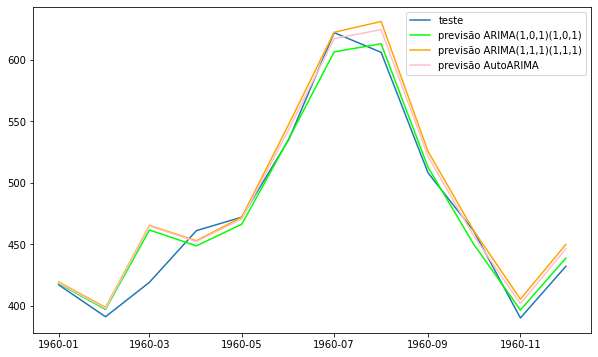

In [77]:
# Plotando a série com dados reais e ajustados pelo modelo
fig, ax = plt.subplots(figsize = (10,6), ncols = 1, nrows = 1)
plt.plot(st_teste, label='teste')
plt.plot(previsao_arima_1_0_1_1_0_1,color='lime', label='previsão ARIMA(1,0,1)(1,0,1)')
plt.plot(previsao_arima_1_1_1_1_1_1,color='orange', label='previsão ARIMA(1,1,1)(1,1,1)')
plt.plot(st_previsao_AUTOARIMA,color='pink', label='previsão AutoARIMA')
plt.legend(loc='best')
plt.show()

## **Previsão com Prophet**

$y(t) = g(t) + s(t) + h(t) + e(t)$

### **Criando os conjunto de dados no formato esperado pelo Prophet**

Esse framework da Facebook para previsão de séries temporais exige que os dados de entrada seja um dataframe com duas colunas:
- **ds**: que significa (datastamp) deve ter um formato de datetime esperado pelo Pandas, preferencialmente no formato AAAA-MM-DD se for somente a data ou AAAA-MM-DD HH:MM:SS se for data e hora. 
-**y**: deve ter os dados observados nas datas e que se pretende prever, e ser numérica.

In [78]:
# Criando um df no formato de entrada do prophet
df_treino = pd.DataFrame(
    data = {
      'ds': st_treino.index, 
      'y':st_treino.values
    }
)

# Espiando o df gerado
df_treino

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
127,1959-08-01,559
128,1959-09-01,463
129,1959-10-01,407
130,1959-11-01,362


### **Fazendo a modelagem com o Prophet**

In [79]:
# Importando biblioteca necessária
from fbprophet import Prophet

In [80]:
# Instanciando o modelo
modelo_Prophet = Prophet(seasonality_mode="multiplicative")

In [81]:
# Ajustando o modelo aos dados
modelo_Prophet.fit(df_treino)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### **Fazendo Previsão com o Prophet**

In [82]:
# Criando dataframe com os períodos futuros para as previsões
st_futuro_Prophet = modelo_Prophet.make_future_dataframe(
    periods= 12, 
    freq = 'M', 
    include_history = True
)

# Espiando o df gerado
st_futuro_Prophet

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
139,1960-07-31
140,1960-08-31
141,1960-09-30
142,1960-10-31


In [83]:
# Realizando as previsões
previsao_Prophet = modelo_Prophet.predict(st_futuro_Prophet)

In [84]:
# Entendo a estrutura do df resultante da previsao
previsao_Prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          144 non-null    datetime64[ns]
 1   trend                       144 non-null    float64       
 2   yhat_lower                  144 non-null    float64       
 3   yhat_upper                  144 non-null    float64       
 4   trend_lower                 144 non-null    float64       
 5   trend_upper                 144 non-null    float64       
 6   multiplicative_terms        144 non-null    float64       
 7   multiplicative_terms_lower  144 non-null    float64       
 8   multiplicative_terms_upper  144 non-null    float64       
 9   yearly                      144 non-null    float64       
 10  yearly_lower                144 non-null    float64       
 11  yearly_upper                144 non-null    float64       

In [85]:
# Visualizando somente previsoes das ultimas instâncias
previsao_Prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-07-31,584.512761,572.345548,597.769210
140,1960-08-31,486.857711,474.726480,499.391178
141,1960-09-30,427.400268,414.942812,440.252768
142,1960-10-31,373.529040,360.672548,386.170519
143,1960-11-30,424.312896,410.598918,436.985962


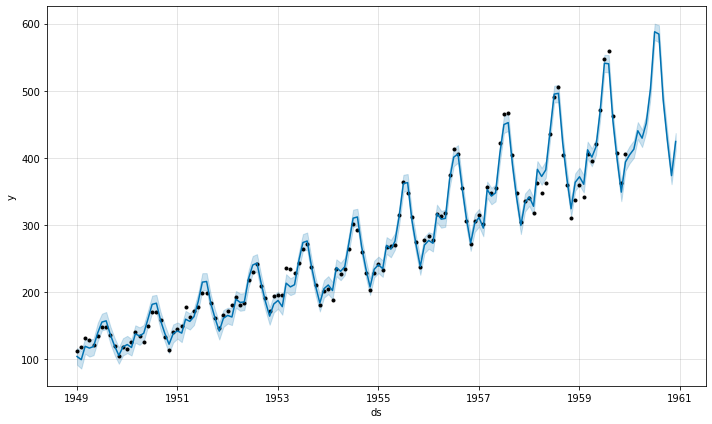

In [86]:
# Fazendo grafico da previsao
grafico_previsao_Prophet = modelo_Prophet.plot(previsao_Prophet)
grafico_previsao_Prophet.show()

### **Avaliando a Previsão com o Prophet**

In [87]:
## Calculando métrica de avaliação do modelo de previsão
## erro médio absoluto (MAE) - meanabs
## raiz do erro quadrático médio (RMSE) - rmse

# Carregando bibliotecas necessárias
#from statsmodels.tools.eval_measures import meanabs, rmse

# Calculando as métricas para previsão com modelo gerado pelo autorima
mae_Prophet = meanabs(
    x1 = st_teste.values,
    x2 = previsao_Prophet['yhat'].tail(12).values
)

rmse_Prophet = rmse(
    x1 = st_teste.values,
    x2 = previsao_Prophet['yhat'].tail(12).values
)

# Verificando as métricas
print('Prophet: MAE = {}'.format(mae_Prophet))
print('Prophet: RMSE = {}'.format(rmse_Prophet))

Prophet: MAE = 22.905205487873413
Prophet: RMSE = 24.31226716021588


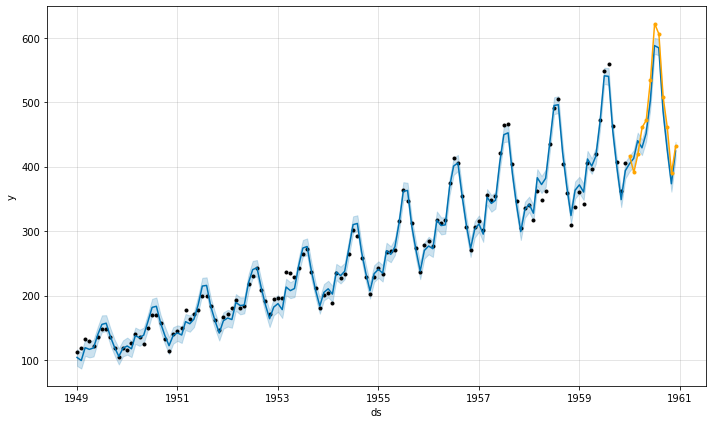

In [227]:
# Inserindo os dados de teste no grafico da previsao
grafico_previsao_Prophet = modelo_Prophet.plot(previsao_Prophet)
plt.plot(st_teste,color='orange', label='dados reais de teste', marker = '.')
grafico_previsao_NeuralProphet.show()

## **Previsão com Neural Prophet**

De acordo com o site oficial do NeuralProphet (https://neuralprophet.com/html/index.html), este framework "*preenche a lacuna entre os modelos tradicionais de séries temporais e os métodos de aprendizado profundo*". 

NeuralProhet é baseado em PyTorch e utiliza deep learning para realizar as previsões. É fácil de instalar (basta usar o pip), pouco verbosa e totalmente transparente, abstrai a complexidade e facilita a utilização permitindo que os usuários consiga relizar suas precisões com escrita fácil dos códigos.

O artigo original do NeuralProphet, intitulado de **NeuralProphet: Explainable Forecasting at Scale** foi submetido em novembro de 2021 por Oskar Triebe, Hansika Hewamalage, Polina Pilyugina, Nikolay Laptev, Christoph Bergmeir e Ram Rajagopal por ser acessado pelo link: https://arxiv.org/abs/2111.15397 .

### **Fazendo a modelagem com o Neural Prophet**

In [88]:
# Importando a função NeuralProphet
from neuralprophet import NeuralProphet

In [89]:
# Instanciando o modelo com ajustes de hyperparâmetros
modelo_NeuralProphet = NeuralProphet(
    growth='linear',
    epochs = 1000, 
    learning_rate=0.01, 
    n_forecasts = 12,
    seasonality_mode="multiplicative"
    )

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values


In [90]:
# Treinando a rede
modelo_NeuralProphet.fit(df = df_treino, freq = "MS")

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.909% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=

,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.422048,285.708694,356.168870,0.0
1,0.419959,284.850748,352.708792,0.0
2,0.417947,284.010997,346.907101,0.0
3,0.416003,283.202931,346.084591,0.0
4,0.414074,282.406037,350.529584,0.0
...,...,...,...,...
995,0.000288,6.934339,8.584773,0.0
996,0.000288,6.934349,8.546515,0.0
997,0.000288,6.934381,8.510284,0.0
998,0.000288,6.934376,8.511552,0.0


### **Fazendo Previsão com o Neural Prophet**

In [91]:
# Criando dataframe com os períodos futuros para as previsões
st_futuro_NeuralProphet = modelo_NeuralProphet.make_future_dataframe(
    df = df_treino,
    periods= 12,
    n_historic_predictions = True
)

# Espiando o df gerado
st_futuro_NeuralProphet

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.909% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS


,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,None
140,1960-09-01,None
141,1960-10-01,None
142,1960-11-01,None


In [92]:
# Realizando as previsões
previsao_NeuralProphet = modelo_NeuralProphet.predict(st_futuro_NeuralProphet)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS


In [93]:
# Espiando o df resultante da previsao
previsao_NeuralProphet

,ds,y,yhat1,residual1,trend,season_yearly
0,1949-01-01,112,119.890045,7.890045,122.651665,-0.148063
1,1949-02-01,118,119.285126,1.285126,123.388741,-0.211650
2,1949-03-01,132,123.756378,-8.243622,124.054489,-0.014865
3,1949-04-01,129,123.514015,-5.485985,124.791565,-0.061446
4,1949-05-01,121,124.910927,3.910927,125.504868,-0.027619
...,...,...,...,...,...,...
139,1960-08-01,None,606.000732,NaN,470.265411,0.370593
140,1960-09-01,None,501.814728,NaN,473.544586,0.076500
141,1960-10-01,None,432.686523,NaN,476.718048,-0.118136
142,1960-11-01,None,372.404388,NaN,479.997253,-0.286153


In [94]:
# Entendo a estrutura do df resultante da previsao
previsao_NeuralProphet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             144 non-null    datetime64[ns]
 1   y              132 non-null    object        
 2   yhat1          144 non-null    float64       
 3   residual1      132 non-null    object        
 4   trend          144 non-null    float64       
 5   season_yearly  144 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 6.9+ KB


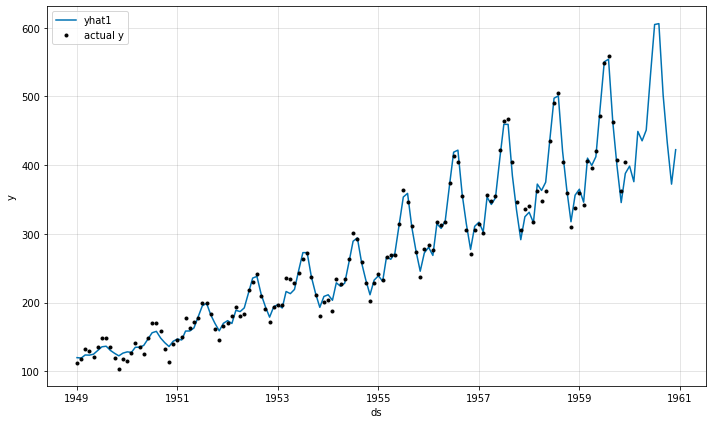

In [95]:
# Fazendo grafico da previsao
grafico_previsao_NeuralProphet = modelo_NeuralProphet.plot(previsao_NeuralProphet)
grafico_previsao_NeuralProphet.show()

### **Avaliando a Previsão com o Neural Prophet**

In [97]:
## Calculando métrica de avaliação do modelo de previsão
## erro médio absoluto (MAE) - meanabs
## raiz do erro quadrático médio (RMSE) - rmse

# Carregando bibliotecas necessárias
from statsmodels.tools.eval_measures import meanabs, rmse

# Calculando as métricas para previsão com modelo gerado pelo autorima
mae_NeuralProphet = meanabs(
    x1 = st_teste.values,
    x2 = previsao_NeuralProphet['yhat1'].tail(12).values
)

rmse_NeuralProphet = rmse(
    x1 = st_teste.values,
    x2 = previsao_NeuralProphet['yhat1'].tail(12).values
)

# Verificando as métricas
print('NeuralProphet: MAE = {}'.format(mae_NeuralProphet))
print('NeuralProphet: RMSE = {}'.format(rmse_NeuralProphet))

NeuralProphet: MAE = 16.02465565999349
NeuralProphet: RMSE = 18.506652934618135


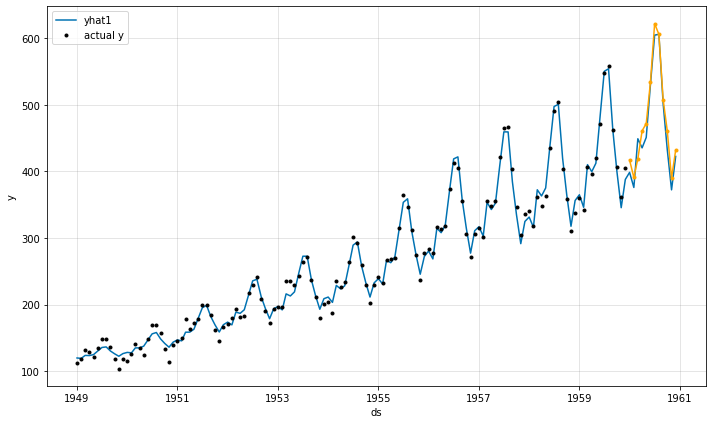

In [96]:
# Inserindo os dados de teste no grafico da previsao
grafico_previsao_NeuralProphet = modelo_NeuralProphet.plot(previsao_NeuralProphet)
plt.plot(st_teste,color='orange', label='dados reais de teste', marker = '.')
grafico_previsao_NeuralProphet.show()